In [1]:
import os
import pandas as pd
data = pd.read_csv('data/data.csv', header=None)
data

,0,1,2,3
0,300000,«Наёмники блокчейна» — как ими становятся?,"['Dash', 'блокчейн', 'криптовалюта', 'управлен...",data/habr/post__300000.txt
1,300002,Динамичность должна быть безопасной,"['стартапы', 'программы', 'разработка программ...",data/habr/post__300002.txt
2,300004,Издательства выступают против блокировщика рек...,"['mozilla', 'Brave', 'блокировщики рекламы', '...",data/habr/post__300004.txt
3,300006,"Выход из зоны комфорта, как новая бизнес-модель","['бизнес-модель', 'it', 'стартап', 'интернет',...",data/habr/post__300006.txt
4,300008,«Уберизация» поможет российскому рынку рекрути...,"['mail.ru group', 'headhunter', 'российский ры...",data/habr/post__300008.txt
...,...,...,...,...
177,300390,Капитализация Kamcord превысила $100 млн после...,"['Time Warner', 'time warner cable', 'kamcord'...",data/habr/post__300390.txt
178,300392,Конференция ISDEF-2016 в Казани: почему это бы...,"['isdef', 'конференция', 'ит-бизнес', '\n ...",data/habr/post__300392.txt
179,300394,AVO и другие альтернативы роумингу,"['роуминг', 'voip', 'конкуренты', 'стартапы', ...",data/habr/post__300394.txt
180,300396,Шпаргалка в офис: ключевые метрики для развити...,"['метрики', 'развитие бизнеса', '\n ...",data/habr/post__300396.txt


In [2]:
from utils import read_file
publications = [read_file(path) for path in data[3]]
joined_publications = ' '.join(publications)

In [3]:
import matplotlib.pyplot as plt
from wordcloud import  WordCloud

def plot_wordcloud(text, title=''):
    plt.figure(figsize=(8,10))
    wc = WordCloud(max_words=1000, random_state=1).generate(text)
    plt.title(title)
    plt.imshow(wc)
    plt.show()

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Предобработки
- Удаление пробельных символов
- Удаление спец символов
- Токенезация
- Удаление стандартного списка стоп-слов
- Удаление чисел
- Приведение к нижнему регистру

In [5]:
import re
from utils import compose
def remove_stopwords(stop_words):
    return lambda tokens: (token for token in tokens if token.lower() not in stop_words)
def tolower(tokens):
    return (token.lower() for token in tokens)
def tokenize(text):
    return word_tokenize(text, language='russian')   
def remove_numbers(tokens):
    def is_number(string):
        try:
            float(string)
            return True
        except ValueError:
            return False
    return (token for token in tokens if not is_number(token))
def remove_spaces(text):
    return re.sub(r'\s', ' ', text)
def remove_symbols(symbols, separator=' '):
    return lambda text: re.sub(symbols + '+', separator, text)
def remove_single(tokens):
    return (token for token in tokens if len(token) != 1)

## Специальные символы
- Арифметические операции
- Знаки препинания
- Различные скобки
- Слэши
- "Мягкий" дефис: \xad 
- А также $, #, №, @, €, •

In [6]:
special_symbols = r'''[-+\%*;:\'"()[\]^$#№@!.,?/|\\<>{}—«»€•–]'''
xad_symbol = r'''\xad'''

In [7]:
default_stop_words = set((stopword.lower() for stopword in stopwords.words('russian')))
remove_default_stopwords = remove_stopwords(default_stop_words)

In [8]:
import json
with open('stopwords.json', 'r', encoding='utf-8') as f:
    own_stop_words = set((stopword.lower() for stopword in json.loads(f.read())))
remove_own_stopwords = remove_stopwords(own_stop_words)

In [9]:
preprocesses = [remove_spaces, remove_symbols(special_symbols), remove_symbols(xad_symbol, ''), tokenize, remove_default_stopwords, remove_own_stopwords, remove_single, remove_numbers, tolower]

In [10]:
preprocessed_publications = [' '.join(compose(preprocesses)(publication)) for publication in publications]
joined_preprocessed_publications = ' '.join(preprocessed_publications)


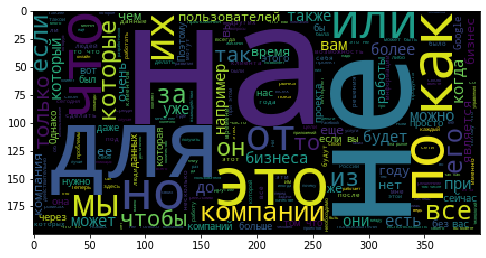

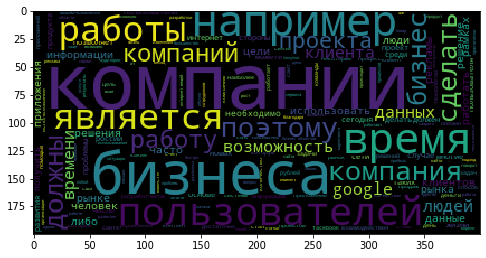

In [11]:
plot_wordcloud(joined_publications)
plot_wordcloud(joined_preprocessed_publications)

## Меры
- Обычная Евклидова [0, ∞)
- Нормализованная Евклидова \[0, 2]
- Косинусное расстояние \[0, 1]

In [12]:
import scipy as sp
def simple_eucl(v1, v2):
    delta = v1 - v2
    return sp.linalg.norm(delta.toarray())
def normal_eucl(v1, v2):
    normal_v1 = v1 / sp.linalg.norm(v1.toarray())
    normal_v2 = v2 / sp.linalg.norm(v2.toarray())
    delta = normal_v1 - normal_v2
    return sp.linalg.norm(delta.toarray())
def cosine(v1, v2):
    return sp.spatial.distance.cosine(v1.toarray(), v2.toarray())

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
def make_vectorizer(src, min_df=1, max_df=1.5, *, verbose=False, request=None):
    vectorizer = CountVectorizer(min_df=min_df, max_df=max_df)
    x_train = vectorizer.fit_transform(src)
    if verbose:
        sample_count, feature_count = x_train.shape
        print(f'titles_count={sample_count}, words_count={feature_count}')
    if request:
        return vectorizer, x_train, vectorizer.transform([request])
    return vectorizer, x_train

In [14]:
def get_distances(dist_func, src):
    return sorted(((dist_func(x_train.getrow(idx), request_vec), text, idx) for idx, text in enumerate(src)), key=lambda x: x[0])

In [15]:
def check_results(src, count=1):
    total = [(dist, get_distances(dist, src)[:count]) for dist in distances]
    for dist_func, dist_res  in total:
        print(f'-----------{dist_func.__name__}-----------')
        for idx, res in enumerate(dist_res):
            print(f'{idx + 1}. Best publication is {res[2]} with distance = {res[0]} :\n {res[1][:100]}')
    return total

In [16]:
request = 'большие данные'
distances = [simple_eucl, normal_eucl, cosine]

In [17]:
vectorizer, x_train, request_vec = make_vectorizer(publications, verbose=True, request=request)
results = check_results(publications, 5)

titles_count=182, words_count=26711
-----------simple_eucl-----------
1. Best publication is 25 with distance = 7.0 :
 В последнее время участились жалобы зарубежных клиентов на то, что они не могут оплатить услуги «Мое
2. Best publication is 11 with distance = 8.0 :
 Как всегда в понедельник, короткая подборка того, что вы могли пропустить за выходные дни.

Динамичн
3. Best publication is 88 with distance = 9.273618495495704 :
 Как всегда в понедельник, короткая подборка того, что вы могли пропустить за выходные дни.

Почему б
4. Best publication is 62 with distance = 9.433981132056603 :
 Привет!

Вот уже почти два года я живу и работаю в Гамбурге. В августе прошлого года я начал вести в
5. Best publication is 165 with distance = 11.832159566199232 :
 Как всегда в понедельник, короткая подборка того, что вы могли пропустить за выходные дни.

Ларри Пе
-----------normal_eucl-----------
1. Best publication is 156 with distance = 1.1192180351653005 :
 Действительно ли big data – это объек

In [18]:
vectorizer, x_train, request_vec = make_vectorizer(preprocessed_publications, verbose=True, request=request)
preprocessed_results = check_results(preprocessed_publications, 5)

titles_count=182, words_count=26155
-----------simple_eucl-----------
1. Best publication is 25 with distance = 5.656854249492381 :
 последнее время участились жалобы зарубежных клиентов оплатить услуги моего круга одним предлагаемых
2. Best publication is 11 with distance = 6.855654600401044 :
 понедельник короткая подборка могли пропустить выходные дни динамичность должна безопасной издательс
3. Best publication is 62 with distance = 7.14142842854285 :
 привет живу работаю гамбурге августе прошлого начал вести влог котором делюсь своими впечатлениями ж
4. Best publication is 88 with distance = 8.426149773176359 :
 понедельник короткая подборка могли пропустить выходные дни большинство онлайн маркетологов профнепр
5. Best publication is 165 with distance = 9.797958971132712 :
 понедельник короткая подборка могли пропустить выходные дни ларри пейдж еженедельной рубрике бизнес 
-----------normal_eucl-----------
1. Best publication is 156 with distance = 1.012139240479355 :
 big data объ

In [19]:
matrix = pd.DataFrame(data={'Not Preprocessed': {func.__name__: res[0][0] for func, res in results}, 'Preprocessed': {func.__name__: res[0][0] for func, res in preprocessed_results}}).transpose()
matrix

,simple_eucl,normal_eucl,cosine
Not Preprocessed,7.000000,1.119218,0.626325
Preprocessed,5.656854,1.012139,0.512213
